# Robotics Project

Name : Abdallah Atef Hefny

ID : 201364

In [1]:
# import useful lib
import numpy as np
import time
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

# Forward Kinematics

In [2]:
# functions of forward kinematics
def FK(theta, alpha, a, d):
    #conversion of theta to radians
    theta = np.radians(theta)
    # cos and sin theta
    cth= np.cos(theta); sth= np.sin(theta)
    #conversion of alpha to radians 
    alpha= np.radians(alpha)
    # cos and sin alpha
    cal= np.cos(alpha); sal= np.sin(alpha)
    # This matrix is for DH transformation
    matrix = np.array([[cth, -sth*cal, sth*sal, a*cth]
                       ,[sth, cth*cal, -sal*cth, a*sth]
                       , [0, sal, cal, d] ,
                       [0, 0, 0, 1]])
    return np.round(matrix,3)

# DH table

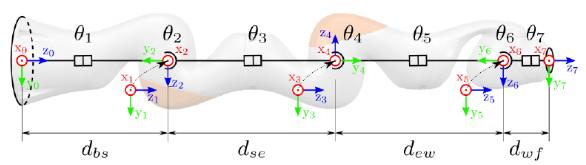

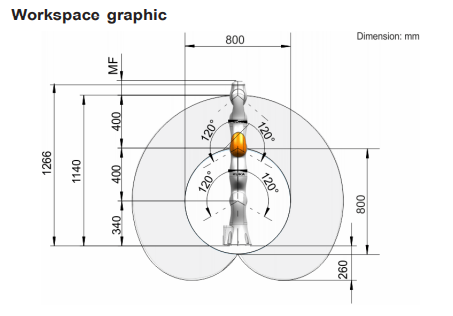


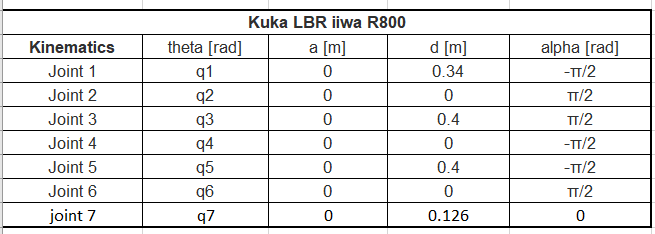

In [3]:
# Transformations of DH table
q = np.zeros(7)
a = np.zeros(7)
alpha = np.array([-90,90,90,-90,-90,90,0])
d = np.array([0.34,0,0.4,0,0.4,0,0.126])
for i in range(len(q)):
    q[i] = input("please enter the %s angle" %str(i+1))
print(q)
T1 = FK(q[0], alpha[0], a[0], d[0])
T2 = FK(q[1], alpha[1], a[1], d[1])
T3 = FK(q[2], alpha[2], a[2], d[2])
T4 = FK(q[3], alpha[3], a[3], d[3])
T5 = FK(q[4], alpha[4], a[4], d[4])
T6 = FK(q[5], alpha[5], a[5], d[5])
T7 = FK(q[6], alpha[6], a[6], d[6])

T0_7 = np.round(T1@T2@T3@T4@T5@T6@T7,2)
print(T0_7)

please enter the 1 angle 0
please enter the 2 angle 0
please enter the 3 angle 0
please enter the 4 angle 0
please enter the 5 angle 0
please enter the 6 angle 0
please enter the 7 angle 0


[0. 0. 0. 0. 0. 0. 0.]
[[1.   0.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   1.27]
 [0.   0.   0.   1.  ]]


In [4]:
client = RemoteAPIClient()
sim = client.require('sim')

defaultIdleFps = sim.getInt32Param(sim.intparam_idle_fps)
sim.setInt32Param(sim.intparam_idle_fps, 0)

1

In [5]:
#Getting names of joints 
joint_names = [f'joint_{i+1}' for i in range(7)]
#Handels of the joints
joint_handles=[sim.getObjectHandle(name) for name in joint_names]
#Assume that the EE is the connection of the last link with the end effector
EE_connection = sim.getObjectHandle("EE_frame")
#Lets start
sim.addLog(sim.verbosity_scriptinfos, "Starting the program")

#Graph configuration

EE_graph = sim.getObjectHandle("graph")

EE_x = sim.addGraphStream(EE_graph,"End Effector X position","m",0,[0,1,1])
EE_y = sim.addGraphStream(EE_graph,"End Effector Y position","m",0,[0,0,1])
EE_z = sim.addGraphStream(EE_graph,"End Effector Z position","m",0,[0,1,0])

sim.addGraphCurve(EE_graph,"Position",3,[EE_x,EE_y,EE_z],[0,0,0],"m by m")

10000

In [6]:
# lets start the simulation
client.setStepping(False)
sim.startSimulation()
#enable the position control for all joints
for i in range(len(joint_handles)):
    sim.setObjectInt32Parameter(joint_handles[i],2001,~0)

for i in range(len(q)):
    sim.setJointTargetPosition(joint_handles[i],np.radians(q[i]))
Robotbase = sim.getObjectHandle("base_frame")

In [7]:

time.sleep(5)
# position of the End Effector
EE_pos = sim.getObjectPosition(EE_connection,Robotbase)
print("position of the end effector is \n",np.round(EE_pos,2))
# transformation matrix
EE_T = np.round(sim.getObjectMatrix(EE_connection,Robotbase),2)
EE_T = EE_T.reshape(3,4)
print("Transformation matrix of the arm from vrep\n",EE_T)
print("Transformation matrix of the arm from the calculations\n",T0_7)

ret=sim.getGraphCurve(EE_graph,0 ,0)
sim.stopSimulation()

# Restore the original idle loop frequency:
sim.setInt32Param(sim.intparam_idle_fps, defaultIdleFps)
print('Program ended')

position of the end effector is 
 [0.   0.   1.26]
Transformation matrix of the arm from vrep
 [[ 1.    0.    0.    0.  ]
 [-0.    1.   -0.    0.  ]
 [-0.    0.    1.    1.26]]
Transformation matrix of the arm from the calculations
 [[1.   0.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   1.27]
 [0.   0.   0.   1.  ]]
Program ended


# Inverse Kinematics 

Jaccobian method

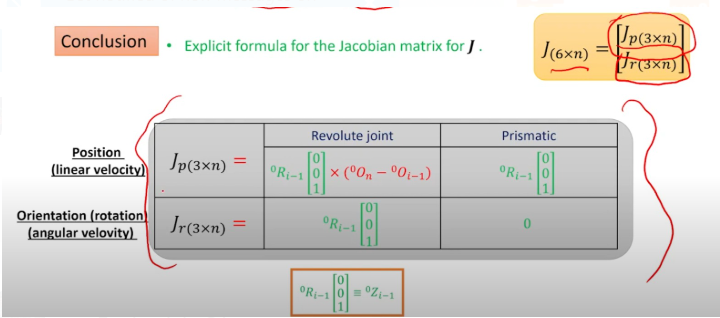

In [8]:
def jacobian_matrix(q,alpha,a,d):
    # calculate the T0_i-1 for every joint
    # identity 
    Ts = []
    Ti = np.eye(4)
    Ts.append(Ti)
    for i in range(len(q)):
        Ti= Ti @ FK(q[i], alpha[i], a[i], d[i])
        Ts.append(Ti)
    # Ts is an array of arrays from this array we can get the O and Z matrices for every transformation matrix
    # getting O matrices for every joint
    O = [T[:3, 3] for T in Ts]
    # getting Z matrices for every joint
    Z = [T[:3, 2] for T in Ts]
    J = np.zeros((6,len(q)))
    # explicit jacobian matrix
    for i in range(len(q)):
        J[:3, i] = np.cross(Z[i], O[-1]- O[i])
        J[3:, i] = Z[i]
    return J

In [9]:
# testing the function and extracting the explicit jacobian
my_jac = jacobian_matrix(q,alpha,a,d)
print(my_jac)

[[ 0.     0.926  0.    -0.526  0.     0.126  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     1.     0.    -1.     0.     1.     0.   ]
 [ 1.     0.     1.     0.     1.     0.     1.   ]]


Inverse kinamatics
Newton Raphson 

In [10]:
# first  function is to check if the desired point is in the workspace of robot
def inworkspace_limits(P_desired):
    x, y, z = P_desired
    # these values are from the datasheet of Kuka LBR iiwa 7 R800
    # dimensions must be in m 
    return -0.8<= x <= 0.8 and -0.8<= y <= 0.8 and -0.8<= z <= 0.8
    

In [11]:
#this function uses the FK function to drive the DH-transformation matrix of our robot
def chain_of_FK(q, alpha, a, d):
    T = np.eye(4)
    for i in range(len(q)):
        T = T @ FK(q[i], alpha[i], a[i], d[i])
    return np.round(T,2)

In [12]:
#calculating the angular
def rot_error(desired_rot, current_rot):
    error_matrix = (desired_rot@current_rot.T) - np.eye(3) 
    error_vec = np.array([
        error_matrix[2,1],
        error_matrix[0,2],
        error_matrix[1,0]
    ])
    return error_vec


In [13]:
def wrap_angle(angle):
    return (angle + 180) % 360 - 180

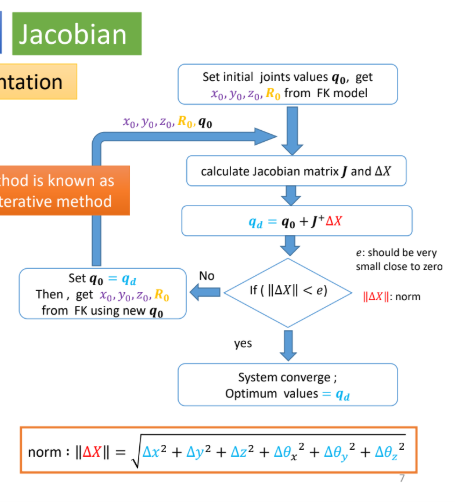

In [120]:
# function for inverse kinematics
def IK(Pos_desired, q_init, alpha, a, d, tolerance= 0.01, damping_factor=0.01):
    # first check the desired position
    if not inworkspace_limits(Pos_desired):
        print("Target position cannot be reached by the manipulator")
        return None
    else:
        Rot_desired = [[0,0,-1],[0,1,0],[1,0,0]]#np.eye(3)
        q = q_init
        for i in range(10000):
            current_TF = chain_of_FK(q, alpha, a, d)
            Pos_current = current_TF[:3,3]
            Rot_current = current_TF[:3,:3]
            pos_delta = Pos_desired - Pos_current
            # assume that the orentation is not important so the error of it is zer0
            rot_delta = rot_error(Rot_desired, Rot_current) 
            delta_X = np.hstack((pos_delta, rot_delta))
            J = jacobian_matrix(q,alpha,a,d)
            J_pesudo = np.linalg.pinv(J)
            delta_q = np.dot(J_pesudo, delta_X)
            q+= delta_q
            q = np.array([wrap_angle(angle) for angle in q])
            if np.linalg.norm(delta_X)<= tolerance :
                break
        print("The angles are ",np.round(q,2))
        return np.round(q,2)

In [94]:
des_pos = [-0.4,-0.7,0.7]
output = IK(des_pos,[0,0,0,0,0,0,0], alpha, a, d)


The angles are  [  58.86  -79.77  170.4    12.02 -170.1    67.94  -61.13]


In [95]:
client = RemoteAPIClient()
sim = client.require('sim')

defaultIdleFps = sim.getInt32Param(sim.intparam_idle_fps)
sim.setInt32Param(sim.intparam_idle_fps, 0)

1

In [96]:
#Getting names of joints 
joint_names = [f'joint_{i+1}' for i in range(7)]
#Handels of the joints
joint_handles=[sim.getObjectHandle(name) for name in joint_names]
#Assume that the EE is the connection of the last link with the end effector
EE_connection = sim.getObjectHandle("EE_frame")
#Lets start
sim.addLog(sim.verbosity_scriptinfos, "Starting the program")

#Graph configuration

EE_graph = sim.getObjectHandle("graph")

EE_x = sim.addGraphStream(EE_graph,"End Effector X position","m",0,[0,1,1])
EE_y = sim.addGraphStream(EE_graph,"End Effector Y position","m",0,[0,0,1])
EE_z = sim.addGraphStream(EE_graph,"End Effector Z position","m",0,[0,1,0])

sim.addGraphCurve(EE_graph,"Position",3,[EE_x,EE_y,EE_z],[0,0,0],"m by m")

10000

In [97]:
# lets start the simulation
client.setStepping(False)
sim.startSimulation()
#enable the position control for all joints
for i in range(len(joint_handles)):
    sim.setObjectInt32Parameter(joint_handles[i],2001,~0)

for i in range(len(output)):
    sim.setJointTargetPosition(joint_handles[i],np.radians(output[i]))
Robotbase = sim.getObjectHandle("base_frame")

In [98]:
time.sleep(5)
# position of the End Effector
EE_pos = sim.getObjectPosition(EE_connection,Robotbase)
print("position of the end effector is \n",np.round(EE_pos,2))
# transformation matrix
EE_T = np.round(sim.getObjectMatrix(EE_connection,Robotbase),2)
EE_T = EE_T.reshape(3,4)
#calculate the forward kinematics
TF = chain_of_FK(output, alpha, a, d)

print("Transformation matrix of the arm from vrep\n",EE_T)
print("Transformation matrix of the arm from the calculations\n",TF)

ret=sim.getGraphCurve(EE_graph,0 ,0)
sim.stopSimulation()

# Restore the original idle loop frequency:
sim.setInt32Param(sim.intparam_idle_fps, defaultIdleFps)
print('Program ended')

position of the end effector is 
 [-0.38 -0.66  0.68]
Transformation matrix of the arm from vrep
 [[ 1.    0.    0.01 -0.38]
 [-0.    1.   -0.01 -0.66]
 [-0.01  0.01  1.    0.68]]
Transformation matrix of the arm from the calculations
 [[ 1.    0.    0.   -0.38]
 [-0.    1.   -0.   -0.66]
 [-0.    0.    1.    0.69]
 [ 0.    0.    0.    1.  ]]
Program ended


# interpolation

In [99]:
client = RemoteAPIClient()
sim = client.require('sim')

defaultIdleFps = sim.getInt32Param(sim.intparam_idle_fps)
sim.setInt32Param(sim.intparam_idle_fps, 0)

1

In [100]:
#Drawing the path using coppilasim trajectory planner
pathHandle = sim.getObjectHandle("Path_num2")

pathData = sim.unpackDoubleTable(sim.getBufferProperty(pathHandle, 'customData.PATHCTRLPTS'))

In [101]:
sim.stopSimulation()

# Restore the original idle loop frequency:
sim.setInt32Param(sim.intparam_idle_fps, defaultIdleFps)

1

In [102]:
# points in the draw then the interpolation will be while drawing

points = [[-0.4,-0.7,0.7],#first point of first number
          [-0.4,-0.6,0.7],
          [-0.4,-0.6,0.5],
          [-0.4,-0.7,0.5],
          [-0.4,-0.7,0.2],
          [-0.4,-0.6,0.2],# lastof the the first number
          [-0.4,-0.4,0.7],#first
          [-0.4,-0.3,0.7],
          [-0.4,-0.3,0.2],
          [-0.4,-0.4,0.2],
          [-0.4,-0.4,0.7],#last
          [-0.4,-0.1,0.7],#first
          [-0.4,-0.1,0.2],#last
          [-0.4,0,0.7],#first
          [-0.4,0.1,0.7],
          [-0.4,0.1,0.5],
          [-0.4,0,0.5],
          [-0.4,0.1,0.5],
          [-0.4,0.1,0.2],
          [-0.4,0,0.2],#last
          [-0.4,0.4,0.7],#first
          [-0.4,0.3,0.7],
          [-0.4,0.3,0.2],
          [-0.4,0.4,0.2],
          [-0.4,0.4,0.5],
          [-0.4,0.3,0.5],# last
          [-0.4,0.6,0.7],#first
          [-0.4,0.6,0.5],
          [-0.4,0.7,0.5],
          [-0.4,0.7,0.7],
          [-0.4,0.7,0.2]         
]


In [162]:
def calculate_angles(q,alpha,d,a,points,steps = 50):
    q_init = q
    q_total = []
    for i in range(len(points) - 1):
        P_start = np.array(points[i])
        P_end = np.array(points[i + 1])
        num_steps = steps
        for t in np.linspace(0, 1, num_steps):
            P_intermediate = (1 - t) * P_start + t * P_end
            q_target = IK(P_intermediate, q_init, alpha, a, d)
            q_total.append(q_target)
    return q_total

In [135]:
angles2 = calculate_angles([0,0,0,0,0,0,0],alpha,d,a,points)

The angles are  [-114.53   60.98 -143.06    9.54 -119.47  -73.73   67.18]
The angles are  [  80.57  -64.19   88.69  -21.63 -172.88  -60.15   59.56]
The angles are  [  47.97  -57.89 -106.21  -38.57   30.74  -86.99   70.83]
The angles are  [  90.36  -70.82 -111.03   41.08   23.38  -52.77   52.33]
The angles are  [  14.18  -46.08 -100.06  -99.9    36.5  -111.83   85.67]
The angles are  [  55.54  -59.78 -111.1   -25.07   32.78  -81.5    69.01]
The angles are  [  65.09  -63.37 -109.49   -5.99   29.16  -73.31   63.68]
The angles are  [  63.02  -62.29 -113.17  -10.33   33.19  -75.1    65.01]
The angles are  [  36.52  -45.42 -120.6   -67.07   45.57  -94.39   85.88]
The angles are  [  43.79  -48.73 -123.65  -53.39   46.47  -89.34   81.97]
The angles are  [  59.48  -59.53 -119.67  -17.88   40.36  -77.54   67.92]
The angles are  [ 6.8010e+01 -6.3740e+01 -1.3898e+02 -2.0000e-02  5.8830e+01 -7.0320e+01
  6.1870e+01]
The angles are  [ 6.8000e+01 -6.3740e+01 -1.3709e+02 -1.0000e-02  5.6910e+01 -7.033

# Writing ID 

In [163]:
client = RemoteAPIClient()
sim = client.require('sim')

defaultIdleFps = sim.getInt32Param(sim.intparam_idle_fps)
sim.setInt32Param(sim.intparam_idle_fps, 0)

1

In [164]:
#Getting names of joints 
joint_names = [f'joint_{i+1}' for i in range(7)]
#Handels of the joints
joint_handles=[sim.getObjectHandle(name) for name in joint_names]
#Assume that the EE is the connection of the last link with the end effector
EE_connection = sim.getObjectHandle("EE_frame")
#Lets start
sim.addLog(sim.verbosity_scriptinfos, "Starting the program")

#Graph configuration

EE_graph = sim.getObjectHandle("graph")

EE_x = sim.addGraphStream(EE_graph,"End Effector X position","m",0,[0,1,1])
EE_y = sim.addGraphStream(EE_graph,"End Effector Y position","m",0,[0,0,1])
EE_z = sim.addGraphStream(EE_graph,"End Effector Z position","m",0,[0,1,0])

sim.addGraphCurve(EE_graph,"Position",3,[EE_x,EE_y,EE_z],[0,0,0],"m by m")

10000

In [165]:
# lets start the simulation
client.setStepping(False)
sim.startSimulation()
#enable the position control for all joints
for i in range(len(joint_handles)):
    sim.setObjectInt32Parameter(joint_handles[i],2001,~0)

for i in range(len(angles2)):
    q_target = angles2[i]
    for j in range(len(joint_handles)):
                sim.setJointTargetPosition(joint_handles[j], np.radians(q_target[j]))
        


Robotbase = sim.getObjectHandle("base_frame")

In [159]:
sim.stopSimulation()

# Restore the original idle loop frequency:
sim.setInt32Param(sim.intparam_idle_fps, defaultIdleFps)
print("the project is end")

the project is end
